---
## Setup

Import modules

In [23]:
import os
import sys
import io
import copy

from Bio import Phylo
import pandas as pd
import treetime
import matplotlib.pyplot as plt
import numpy as np

Input file paths

In [24]:
# Use branch support tree since the node names are fixed
tree_path = "../../docs/results/latest/branch_support/branch_support.nwk"
tree_df_path = "../../docs/results/latest/mugration/mugration.tsv"
outdir = "../../docs/results/latest/timetree/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

Variables

In [3]:
# Data, columns, colors
NO_DATA_CHAR = "NA"
DATE_COL = "Date"
TERM_COL = "grey"

BRANCH_LEN_SIG_DIG = 12

# Alignment parameters
REF_LEN = 4653728

# Relaxed clock parameters
# Slack around 1.0 correspond to weak priors, larger values constrain rate deviations more strongly.
# I'm pretty sure we want a weak prior, since the distribution of rate deviation is lognormal
SLACK = 1
# Coupling 0 (–relax 1.0 0) corresponds to an un-correlated clock.
COUPLING = 0
CONFIDENCE = 0.95
# Offset for mutations: 0 will be 1-based
offset = 0

# Number of interquartile distances to identify outliers
N_IQD = 3

# Number of iterations 
MAX_ITER = 3

# Branch Length Optimization
# For more divergent sequences, iterative optimization will underestimate the branch lengths
# What is "divergent"? treetime data is a lot of epidemic viral phylo, so I think bacterial history is divergent
BL_MODE = "input"
ml_mode = "marginal" # Shaw et al. (2019) demonstrate joint is bad
title = "Uncorrelated Relaxed Clock"
file_prefix = "uncorrelated-relaxed-clock"

#present = datetime.date.today().year

#random.seed(131495)

# FIRST! Try to estimate clock rate from data. See how it compares to literature.
# For many bacterial data set were the temporal signal in the data is weak, 
# it is advisable to fix the rate of the molecular clock explicitly. 
# Divergence times, however, will depend on this choice
# Cui 2013 (cites Morelli 2010) contrains the mean to 1e-8
#clock_rate = 1e-8
# Spyrou et al. 2019 observed a rate variation from 2.09E–7 to 4.95E–9
# Mean substituion rate was 2.85E–8
# clock_rate = 2e-8

### Read input tree

In [4]:
tree_div = Phylo.read(tree_path, "newick")
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

### Read input dataframe

In [6]:
# Select tips
dates_df = tree_df[tree_df["Branch_Support_Color"] == "grey"]
# Select only the date column
dates_df = dates_df[[DATE_COL]].copy()

# TEMPORARY
dates_df.at["Reference",DATE_COL] = 1992

# Save tree dataframe to a tmp file
tmp_tsv = os.path.join(outdir, "tmp.tsv" )
dates_df.to_csv(tmp_tsv, sep="\t")

### Parse dates

In [7]:
dates = treetime.utils.parse_dates(tmp_tsv, date_col=DATE_COL)


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
## Timetree Analysis

In [8]:
# Basic initialize, fine tuning comes in next step
#tt_relaxed = treetime.TreeTime(tree = tree_div,
tt_relaxed = treetime.TreeTime(tree = tree_div,
                      #aln = aln_path,
                      seq_len=REF_LEN,
                      verbose = 4,
                      dates = dates,
                      branch_length_mode = BL_MODE,
                      )


0.00	-TreeAnc: set-up

0.02	-###TEST.TreeAnc.prepare_tree: BEGIN
0.18	--ClockTree: Setting precision to level 2

0.24	-ClockTree._assign_dates: assigned date contraints to 523 out of 523 tips.


In [9]:
for item in tt_relaxed.date_dict:
    print(item, tt_relaxed.date_dict[item])

GCA_000269265.1_ASM26926v1_genomic 2010.0
GCA_000269385.1_ASM26938v1_genomic 2010.0
GCA_000269285.1_ASM26928v1_genomic 2010.0
GCA_000269285.2_ASM26928v2_genomic 2010.0
GCA_000268945.1_ASM26894v1_genomic 2010.0
GCA_000269105.1_ASM26910v1_genomic 2010.0
GCA_000269125.1_ASM26912v1_genomic 2010.0
GCA_000268465.1_ASM26846v1_genomic 2008.0
GCA_000269365.1_ASM26936v1_genomic 2010.0
GCA_000269245.1_ASM26924v1_genomic 2010.0
GCA_000269485.1_ASM26948v1_genomic 2010.0
GCA_000269165.1_ASM26916v1_genomic 2010.0
GCA_000268665.1_ASM26866v1_genomic 2010.0
GCA_000268685.1_ASM26868v1_genomic 2010.0
GCA_000268485.2_ASM26848v2_genomic 2009.0
GCA_000311885.1_ASM31188v1_genomic 2010.0
GCA_000268485.1_ASM26848v1_genomic 2009.0
GCA_000268725.1_ASM26872v1_genomic 2010.0
GCA_000268725.2_ASM26872v2_genomic 2010.0
GCA_000268905.1_ASM26890v1_genomic 2010.0
GCA_000268845.1_ASM26884v1_genomic 2010.0
GCA_000269445.1_ASM26944v1_genomic 2010.0
GCA_000268805.1_ASM26880v1_genomic 2010.0
GCA_000268805.2_ASM26880v2_genomic

SAMEA5661365 [500.0, 650.0]
SAMEA5661363 [474.0, 637.0]
SAMEA5661364 [500.0, 650.0]
SAMEA1061800 [214.0, 261.0]
GCA_009667945.1_ASM966794v1_genomic 1986.0
GCA_009669665.1_ASM966966v1_genomic 2002.0
GCA_009670105.1_ASM967010v1_genomic 1989.0
GCA_009670545.1_ASM967054v1_genomic 1983.0
GCA_009669845.1_ASM966984v1_genomic 2001.0
GCA_009669835.1_ASM966983v1_genomic 2001.0
GCA_009669925.1_ASM966992v1_genomic 1999.0
GCA_009669955.1_ASM966995v1_genomic 2000.0
GCA_009670585.1_ASM967058v1_genomic 1982.0
GCA_009669805.1_ASM966980v1_genomic 1980.0
GCA_009669565.1_ASM966956v1_genomic 2005.0
GCA_009669875.1_ASM966987v1_genomic 2001.0
GCA_009670345.1_ASM967034v1_genomic 1987.0
GCA_009670785.1_ASM967078v1_genomic 1976.0
GCA_009670205.1_ASM967020v1_genomic 1988.0
GCA_009669905.1_ASM966990v1_genomic 2001.0
GCA_009670835.1_ASM967083v1_genomic 1976.0
GCA_009667925.1_ASM966792v1_genomic 1987.0
GCA_009670225.1_ASM967022v1_genomic 1987.0
GCA_009670185.1_ASM967018v1_genomic 1988.0
GCA_009670235.1_ASM967023v1_

## Troubleshooting

In [10]:
print(tt_relaxed.data.full_length)
print(tt_relaxed.min_width)
print(tt_relaxed.one_mutation)
#print(tt_relaxed.sequence)
#for item in dir(tt_relaxed):
#    print(item)
#print(dir(tt_relaxed.data))


tt_relaxed.tree.common_ancestor(tt_relaxed.tree.root)

4653728
2.1488148856142863e-06
2.148814885614286e-07


Clade(branch_length=0.0, dist2root=0.0, mutation_length=0.0, name='NODE0', original_length=0.0)

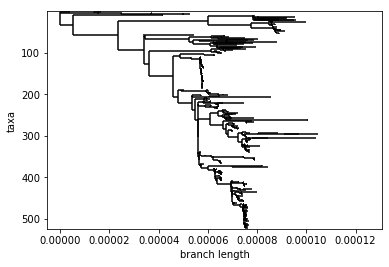

In [11]:
# Check to make sure tree root still looks good...

# Deepest nodes at top
tt_relaxed.tree.ladderize(reverse=False)

Phylo.draw(tt_relaxed.tree,
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)


In [12]:
for c in tt_relaxed.tree.find_clades():
    print(c.name, "\t", c.branch_length, "\t", c.dist2root, "\t", c.mutation_length, "\t", c.original_length)

NODE0 	 0.0 	 0.0 	 0.0 	 0.0
SAMEA3541827 	 3.8915e-06 	 3.8915e-06 	 3.8915e-06 	 3.8915e-06
NODE1008 	 1.37085e-05 	 1.37085e-05 	 1.37085e-05 	 1.37085e-05
SAMEA104233046 	 2.7607e-06 	 1.6469199999999998e-05 	 2.7607e-06 	 2.7607e-06
NODE1009 	 1.1145e-06 	 1.4823e-05 	 1.1145e-06 	 1.1145e-06
SAMEA104233050 	 1.006e-06 	 1.5829e-05 	 1.006e-06 	 1.006e-06
NODE1010 	 9.7423e-06 	 2.45653e-05 	 9.7423e-06 	 9.7423e-06
SAMEA104233047 	 4.923e-07 	 2.50576e-05 	 4.923e-07 	 4.923e-07
NODE1011 	 1.23404e-05 	 3.69057e-05 	 1.23404e-05 	 1.23404e-05
SAMEA104233049 	 1.871e-07 	 3.70928e-05 	 1.871e-07 	 1.871e-07
NODE_0000005 	 1.25504e-05 	 4.94561e-05 	 1.25504e-05 	 1.25504e-05
SAMEA104233048 	 7.824e-07 	 5.0238500000000004e-05 	 7.824e-07 	 7.824e-07
SAMEA3541826 	 3.2202e-06 	 5.26763e-05 	 3.2202e-06 	 3.2202e-06
NODE1 	 5.2248e-06 	 5.2248e-06 	 5.2248e-06 	 5.2248e-06
NODE1005 	 3.63187e-05 	 4.15435e-05 	 3.63187e-05 	 3.63187e-05
GCA_000323485.1_ASM32348v1_genomic 	 2.344e-0

NODE877 	 4.688e-07 	 6.25807e-05 	 4.688e-07 	 4.688e-07
GCA_002188685.1_ASM218868v1_genomic 	 9.1819e-06 	 7.17626e-05 	 9.1819e-06 	 9.1819e-06
NODE878 	 2.34e-08 	 6.260409999999999e-05 	 2.34e-08 	 2.34e-08
GCA_003085955.1_ASM308595v1_genomic 	 1.4064e-06 	 6.401049999999999e-05 	 1.4064e-06 	 1.4064e-06
GCA_003086035.1_ASM308603v1_genomic 	 9.376e-07 	 6.354169999999999e-05 	 9.376e-07 	 9.376e-07
NODE850 	 2.5784e-06 	 6.35183e-05 	 2.5784e-06 	 2.5784e-06
NODE868 	 9.376e-07 	 6.44559e-05 	 9.376e-07 	 9.376e-07
GCA_001972475.1_ASM197247v1_genomic 	 1.01634e-05 	 7.46193e-05 	 1.01634e-05 	 1.01634e-05
GCA_002188755.1_ASM218875v1_genomic 	 7.5333e-06 	 7.19892e-05 	 7.5333e-06 	 7.5333e-06
NODE851 	 4.98e-08 	 6.35681e-05 	 4.98e-08 	 4.98e-08
NODE861 	 2.34e-08 	 6.35915e-05 	 2.34e-08 	 2.34e-08
NODE862 	 2.34e-08 	 6.36149e-05 	 2.34e-08 	 2.34e-08
GCA_000182545.1_ASM18254v1_genomic 	 2.344e-07 	 6.38493e-05 	 2.344e-07 	 2.344e-07
GCA_003085895.1_ASM308589v1_genomic 	 2.344

GCA_009667885.1_ASM966788v1_genomic 	 2.34e-08 	 5.706259999999999e-05 	 2.34e-08 	 2.34e-08
NODE682 	 2.34e-08 	 5.706259999999999e-05 	 2.34e-08 	 2.34e-08
NODE760 	 2.344e-07 	 5.729699999999999e-05 	 2.344e-07 	 2.344e-07
GCA_009669705.1_ASM966970v1_genomic 	 2.34e-08 	 5.732039999999999e-05 	 2.34e-08 	 2.34e-08
GCA_009670995.1_ASM967099v1_genomic 	 2.344e-07 	 5.753139999999999e-05 	 2.344e-07 	 2.344e-07
NODE683 	 2.34e-08 	 5.708599999999999e-05 	 2.34e-08 	 2.34e-08
GCA_009670325.1_ASM967032v1_genomic 	 2.34e-08 	 5.7109399999999986e-05 	 2.34e-08 	 2.34e-08
NODE684 	 2.34e-08 	 5.7109399999999986e-05 	 2.34e-08 	 2.34e-08
NODE752 	 2.344e-07 	 5.7343799999999984e-05 	 2.344e-07 	 2.344e-07
GCA_009670775.1_ASM967077v1_genomic 	 2.34e-08 	 5.736719999999998e-05 	 2.34e-08 	 2.34e-08
NODE753 	 2.34e-08 	 5.736719999999998e-05 	 2.34e-08 	 2.34e-08
GCA_009670715.1_ASM967071v1_genomic 	 2.34e-08 	 5.739059999999998e-05 	 2.34e-08 	 2.34e-08
NODE754 	 2.34e-08 	 5.739059999999998e-

GCA_000169675.1_ASM16967v1_genomic 	 2.34e-08 	 5.724089999999999e-05 	 2.34e-08 	 2.34e-08
GCA_000320465.1_ASM32046v1_genomic 	 2.34e-08 	 5.724089999999999e-05 	 2.34e-08 	 2.34e-08
NODE640 	 6.5979e-06 	 6.0299399999999994e-05 	 6.5979e-06 	 6.5979e-06
NODE641 	 7.032e-07 	 6.100259999999999e-05 	 7.032e-07 	 7.032e-07
GCA_002412245.1_Y.pestis_A-1691_genomic 	 3.7767e-06 	 6.477929999999999e-05 	 3.7767e-06 	 3.7767e-06
GCA_003074595.1_ASM307459v1_genomic 	 2.34e-08 	 6.102599999999999e-05 	 2.34e-08 	 2.34e-08
NODE644 	 9.376e-07 	 6.1237e-05 	 9.376e-07 	 9.376e-07
GCA_002412255.1_Y.pestis_A-1836_genomic 	 2.45602e-05 	 8.579719999999999e-05 	 2.45602e-05 	 2.45602e-05
GCA_003074535.1_ASM307453v1_genomic 	 2.34e-08 	 6.12604e-05 	 2.34e-08 	 2.34e-08
NODE8 	 1.172e-06 	 5.48501e-05 	 1.172e-06 	 1.172e-06
NODE624 	 3.516e-06 	 5.83661e-05 	 3.516e-06 	 3.516e-06
NODE625 	 7.032e-07 	 5.9069299999999994e-05 	 7.032e-07 	 7.032e-07
NODE626 	 2.344e-07 	 5.930369999999999e-05 	 2.344

GCA_003074275.1_ASM307427v1_genomic 	 2.3838e-06 	 7.800369999999999e-05 	 2.3838e-06 	 2.3838e-06
NODE522 	 2.34e-08 	 7.564329999999999e-05 	 2.34e-08 	 2.34e-08
NODE523 	 4.688e-07 	 7.611209999999999e-05 	 4.688e-07 	 4.688e-07
GCA_006376575.1_ASM637657v1_genomic 	 2.34e-08 	 7.613549999999998e-05 	 2.34e-08 	 2.34e-08
GCA_008630375.1_ASM863037v1_genomic 	 2.602e-06 	 7.871409999999999e-05 	 2.602e-06 	 2.602e-06
NODE526 	 2.34e-08 	 7.566669999999998e-05 	 2.34e-08 	 2.34e-08
GCA_008630435.1_ASM863043v1_genomic 	 2.34e-08 	 7.569009999999998e-05 	 2.34e-08 	 2.34e-08
GCA_009295985.1_ASM929598v1_genomic 	 2.34e-08 	 7.569009999999998e-05 	 2.34e-08 	 2.34e-08
NODE382 	 1.172e-06 	 6.734889999999999e-05 	 1.172e-06 	 1.172e-06
NODE490 	 7.032e-07 	 6.805209999999998e-05 	 7.032e-07 	 7.032e-07
NODE514 	 2.1096e-06 	 7.016169999999999e-05 	 2.1096e-06 	 2.1096e-06
GCA_000324025.1_ASM32402v1_genomic 	 2.344e-07 	 7.039609999999999e-05 	 2.344e-07 	 2.344e-07
NODE515 	 2.34e-08 	 7.018

GCA_001617715.1_Yersinia_pestis_M-519_genomic 	 2.344e-07 	 7.513089999999996e-05 	 2.344e-07 	 2.344e-07
NODE391 	 2.344e-07 	 7.513089999999996e-05 	 2.344e-07 	 2.344e-07
NODE407 	 2.34e-08 	 7.515429999999996e-05 	 2.34e-08 	 2.34e-08
GCA_001617815.1_Yersinia_pestis_M-1453_genomic 	 4.688e-07 	 7.562309999999996e-05 	 4.688e-07 	 4.688e-07
GCA_003085855.1_ASM308585v1_genomic 	 2.097e-07 	 7.536399999999996e-05 	 2.097e-07 	 2.097e-07
NODE392 	 2.34e-08 	 7.515429999999996e-05 	 2.34e-08 	 2.34e-08
GCA_008630395.1_ASM863039v1_genomic 	 7.032e-07 	 7.585749999999996e-05 	 7.032e-07 	 7.032e-07
NODE393 	 4.688e-07 	 7.562309999999996e-05 	 4.688e-07 	 4.688e-07
NODE401 	 2.34e-08 	 7.564649999999995e-05 	 2.34e-08 	 2.34e-08
GCA_008630575.1_ASM863057v1_genomic 	 2.34e-08 	 7.566989999999995e-05 	 2.34e-08 	 2.34e-08
NODE402 	 2.344e-07 	 7.588089999999995e-05 	 2.344e-07 	 2.344e-07
GCA_001613885.1_ASM161388v1_genomic 	 1.172e-06 	 7.705289999999995e-05 	 1.172e-06 	 1.172e-06
GCA_001

NODE262 	 2.34e-08 	 6.512479999999997e-05 	 2.34e-08 	 2.34e-08
GCA_000324765.1_ASM32476v1_genomic 	 2.344e-07 	 6.535919999999997e-05 	 2.344e-07 	 2.344e-07
NODE263 	 2.34e-08 	 6.514819999999997e-05 	 2.34e-08 	 2.34e-08
GCA_000324385.1_ASM32438v1_genomic 	 2.344e-07 	 6.538259999999997e-05 	 2.344e-07 	 2.344e-07
GCA_000325465.1_ASM32546v1_genomic 	 2.344e-07 	 6.538259999999997e-05 	 2.344e-07 	 2.344e-07
NODE255 	 2.34e-08 	 6.512479999999997e-05 	 2.34e-08 	 2.34e-08
GCA_000022825.1_ASM2282v1_genomic 	 2.34e-08 	 6.514819999999997e-05 	 2.34e-08 	 2.34e-08
NODE256 	 2.34e-08 	 6.514819999999997e-05 	 2.34e-08 	 2.34e-08
GCA_000325385.1_ASM32538v1_genomic 	 2.34e-08 	 6.517159999999996e-05 	 2.34e-08 	 2.34e-08
NODE257 	 2.344e-07 	 6.538259999999997e-05 	 2.344e-07 	 2.344e-07
GCA_000324845.1_ASM32484v1_genomic 	 2.344e-07 	 6.561699999999996e-05 	 2.344e-07 	 2.344e-07
GCA_000325365.1_ASM32536v1_genomic 	 2.34e-08 	 6.540599999999996e-05 	 2.34e-08 	 2.34e-08
NODE24 	 5.8865e-

GCA_000268605.1_ASM26860v1_genomic 	 2.34e-08 	 7.440539999999995e-05 	 2.34e-08 	 2.34e-08
NODE36 	 2.34e-08 	 7.435859999999996e-05 	 2.34e-08 	 2.34e-08
GCA_000268565.1_ASM26856v1_genomic 	 2.344e-07 	 7.459299999999995e-05 	 2.344e-07 	 2.344e-07
NODE37 	 2.108e-07 	 7.456939999999996e-05 	 2.108e-07 	 2.108e-07
NODE125 	 4.269e-07 	 7.499629999999995e-05 	 4.269e-07 	 4.269e-07
GCA_000268545.1_ASM26854v1_genomic 	 9.426e-07 	 7.593889999999994e-05 	 9.426e-07 	 9.426e-07
GCA_000269085.1_ASM26908v1_genomic 	 6.39e-08 	 7.506019999999995e-05 	 6.39e-08 	 6.39e-08
NODE38 	 4.25e-08 	 7.461189999999996e-05 	 4.25e-08 	 4.25e-08
NODE120 	 2.344e-07 	 7.484629999999996e-05 	 2.344e-07 	 2.344e-07
GCA_000269045.1_ASM26904v1_genomic 	 2.34e-08 	 7.486969999999996e-05 	 2.34e-08 	 2.34e-08
NODE121 	 1.4064e-06 	 7.625269999999996e-05 	 1.4064e-06 	 1.4064e-06
GCA_000268865.1_ASM26886v1_genomic 	 2.34e-08 	 7.627609999999995e-05 	 2.34e-08 	 2.34e-08
GCA_000268865.2_ASM26886v2_genomic 	 2.3

In [13]:
print("Running timetree analysis...")
# Initialize stdout capture
"""old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout"""

tt_relaxed.run(branch_length_mode = BL_MODE,
               n_iqd=N_IQD,
               root=None,
               infer_gtr=True,
               resolve_polytomies=False,
               relaxed_clock={"slack":SLACK, "coupling":COUPLING},
               max_iter=MAX_ITER,
               Tc="skyline",
               use_covariation=False,
               vary_rate=False,
               time_marginal="assign",
               sequence_marginal=True,
               verbose=4,
               #clock_rate = clock_rate,
              )

# Save stdout to file
"""output = new_stdout.getvalue()
out_path = os.path.join(outdir, "treetime.log") 
with open(out_path, "w") as file:
    file.write(output)
# Restore stdout
sys.stdout = old_stdout"""

print("Finished timetree analysis.")

Running timetree analysis...
15.52	--ClockTree.date2dist: Setting new molecular clock. rate=9.668e-09,
     	  R^2=0.2481

15.54	-###TEST.TreeAnc.prepare_tree: BEGIN

15.70	###TreeTime.run: INITIAL ROUND

15.70	-ClockTree: Maximum likelihood tree optimization with temporal constraints
15.70	--ClockTree.init_date_constraints...
15.70	---ClockTree.init_date_constraints: Initializing branch length
     	   interpolation objects...
18.61	--ClockTree.date2dist: Setting new molecular clock. rate=9.668e-09,
     	  R^2=0.2481
18.65	--ClockTree - Joint reconstruction:  Propagating leaves -> root...
63.00	--ClockTree - Joint reconstruction:  Propagating root -> leaves...

63.19	###TreeTime.run: ITERATION 1 out of 3 iterations

63.19	-TreeTime.run: adding coalescent prior with Tc=const
73.16	--optimized Tc to 0.001278
relaxed_clock {'slack': 1, 'coupling': 0}
73.98	--TreeTime.relaxed_clock: slack=1.000000, coupling=0.000000

74.02	-ClockTree: Maximum likelihood tree optimization with temporal co

In [14]:
# we can convert the branch length to units in years and redraw
#tt_relaxed.branch_length_to_years()
#Phylo.draw(tt_relaxed.tree, label_func=lambda x:'', show_confidence=False)

Make a copy for testing

In [15]:
tt_relaxed_copy = copy.deepcopy(tt_relaxed)

Make sure tree is as expected

In [16]:
for c in tt_relaxed.tree.find_clades():
    print(c.name, c.date, c.numdate, "\t", c.branch_length, "\t", c.dist2root, "\t", c.mutation_length, "\t", c.original_length)
    break

NODE0 -20102-02-01 -20101.915045393096 	 0.0 	 0.0 	 0.0 	 0.0


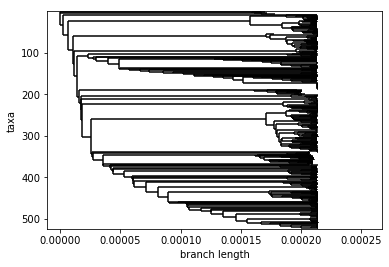

In [17]:
# Check to make sure the root still looks good...

# Deepest nodes at top
tt_relaxed.tree.ladderize(reverse=False)

Phylo.draw(tt_relaxed.tree,
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)


Add node comments

In [22]:
for c in tt_relaxed.tree.find_clades():
    """# Add mutations comment
    if c.mutations:
        mut_comment = 'mutations="' + ','.join([a+str(pos + offset)+d for (a,pos, d) in c.mutations
                                                              if tt_relaxed.gtr.ambiguous not in [a,d]])+'"'
        if c.comment:
            c.comment = ",".join([c.comment, mut_comment])
        else:
            c.comment = "&" + mut_comment
    # Add date comment
    if c.numdate:
        date_comment = 'date={:.2f}'.format(c.numdate)
        if c.comment:
            c.comment = ",".join([c.comment, date_comment])
        else:
            c.comment = "&" + date_comment"""
    
    # Add this info to the dataframe somehow...
    print(c.name, c.numdate)

NODE0 -20101.915045393096
NODE1 -19876.02621984001
NODE2 -19394.58443075428
NODE3 -19033.649541010123
NODE4 -18932.456380271757
NODE5 -18638.81482547165
NODE6 -18506.443961494213
NODE7 -18339.11751780164
NODE8 -18278.599847214005
NODE9 -18229.138193522132
NODE10 -17428.376618738588
NODE11 -17383.225166146734
NODE12 -17312.562526757756
NODE13 -16458.485458268693
NODE14 -16413.794918586827
NODE15 -15845.08344572959
NODE16 -15797.842042698892
NODE17 -15698.935633776528
NODE18 -15587.89950876189
NODE19 -15562.589484545268
NODE20 -14603.207750486072
NODE21 -13921.025680072242
NODE22 -13890.53599774098
NODE23 -13880.812228125555
NODE24 -13735.250771986617
NODE25 -12695.767056982299
NODE26 -11710.746528207346
NODE27 -10815.636901759166
NODE28 -10777.009359601405
NODE29 -9949.565595580885
NODE30 -9264.859330615634
NODE31 -9254.219481339815
NODE32 -9179.218626988506
NODE33 -9141.760574337231
NODE34 -9081.867714522818
NODE35 -8000.074429692241
NODE36 -7172.627813437363
NODE37 -7156.163833366522


IP543 1953.0
GCA_000835005.1_ASM83500v1_genomic 1985.0
SAMEA5054090 1300.0
SAMEA3937654 1362.0
SAMEA5054089 1300.0
NODE325 -3411.385655800731
NODE326 -3183.144314945621
NODE327 -3018.3839328694567
NODE328 -2939.076556402226
NODE329 -2638.228158856892
NODE330 -2199.864140647808
NODE331 -2139.9074111144764
NODE332 -2094.298569403939
NODE333 -1280.6893842416682
NODE334 -467.07938546939863
NODE335 346.53142691368316
NODE336 1118.8131785921792
NODE337 1221.2719962069418
SAMEA5818818 1635.0
SAMEA5818822 1635.0
NODE340 1221.2719962069418
SAMEA5818825 1635.0
SAMEA5818830 1635.0
SAMEA5818829 1635.0
SAMEA5818826 1635.0
SAMEA5818828 1584.868036587642
SAMEA5818821 1485.0
SAMEA5818803 1618.0
SAMEA5818808 1455.0
NODE349 -1244.6184612653112
NODE350 -1150.4389697463482
NODE351 -336.82892063460645
NODE352 50.726388710304946
NODE353 431.34748005494384
NODE354 494.7225183889509
NODE355 1308.272144206942
SAMEA3713711 1720.0
SAMEA3713714 1722.0
NODE358 1699.6912526666567
SAMEA3713712 1722.0
SAMEA3713713 17

GCA_009670995.1_ASM967099v1_genomic 1967.0
GCA_009667885.1_ASM966788v1_genomic 1986.0
GCA_009670865.1_ASM967086v1_genomic 1971.0
NODE765 -6933.616963504964
NODE766 -6106.1693530882
NODE767 -5278.720893222977
NODE768 -4451.271627908489
NODE769 -3623.8215391439117
NODE770 -2796.3705266317465
NODE771 -1968.91877896441
NODE772 -1164.24864113748
NODE773 -1108.2731615181103
NODE774 -280.8197267517205
NODE775 546.6345464689425
NODE776 1316.7859300152186
NODE777 1383.298021207343
NODE778 1993.963342249019
GCA_009669625.1_ASM966962v1_genomic 2005.0
GCA_009670045.1_ASM967004v1_genomic 1995.0
GCA_009669935.1_ASM966993v1_genomic 1995.0
NODE782 1462.6737638516145
NODE783 1985.7361043171036
GCA_009669635.1_ASM966963v1_genomic 2003.0
GCA_009669825.1_ASM966982v1_genomic 2001.0
GCA_009669675.1_ASM966967v1_genomic 2004.0
GCA_009670665.1_ASM967066v1_genomic 1981.0
GCA_009670115.1_ASM967011v1_genomic 1992.0
GCA_009670055.1_ASM967005v1_genomic 1993.0
NODE_0000122 1947.4913415317596
NODE_0000123 1956.343108

GCA_002127355.1_ASM212735v1_genomic 1996.0
GCA_002127365.1_ASM212736v1_genomic 1997.0
GCA_006376585.1_ASM637658v1_genomic 1978.0
GCA_002127375.1_ASM212737v1_genomic 1998.0
GCA_001294825.1_ASM129482v1_genomic 1984.0
NODE1005 1949.8849854856867
GCA_000323485.1_ASM32348v1_genomic 1962.0
GCA_000323845.1_ASM32384v1_genomic 1961.0
NODE1008 -3637.6074528376375
NODE1009 -3465.371841917151
NODE1010 -2890.8767270336466
NODE1011 -2399.5482479149314
NODE_0000005 -1908.875070022
SAMEA104233048 -1881.9999999999998
SAMEA3541826 -1626.0000000000002
SAMEA104233049 -2396.0
SAMEA104233047 -2340.0
SAMEA104233050 -2784.0807299031785
SAMEA104233046 -2472.0
SAMEA3541827 -2876.0


779.12	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years
min_date: -20102.015045393095
date_range: -18086.015045393095
[]


'\nfig.colorbar(cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax, clip = False),cmap=\'Spectral_r\'), ax=ax)\n\n# Save output\nplt.title("Timetree Rate Variation\n(slack={:.1f}; coupling={:.1f})".format(slack, coupling))\nplt.savefig(os.path.join(OUTDIR,"{}_rate-variation.png".format(file_prefix)), dpi=400, bbox_inches = "tight")'

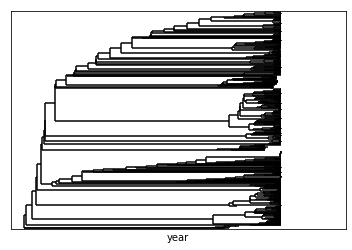

In [19]:
fig = plt.figure()
ax = plt.subplot()

# Flip upside down
tt_relaxed.tree.ladderize(reverse=True)
# Convert branch length to years (root date set to 0.1)
tt_relaxed.branch_length_to_yearss()

# Draw tree to the canvas
Phylo.draw(tt_relaxed.tree, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Problem #1: The x axis is not in the range root.numdate t maximum tip_date
# Problem #2: The x axis is in weird increments

step = 250
axis_pad = 50
date_range = np.max([n.numdate for n in tt_relaxed.tree.get_terminals()]) - offset
#ax.set_xlim(-axis_pad,date_range+axis_pad)
#ax.set_ylim(500,-50)
ax.set_xlabel('year')
ax.set_ylabel('')
ax.set_yticks([])

# Step 1: Figure out offset to convert year branch length to calendar date
min_date = tt_relaxed.tree.root.numdate - tt_relaxed.tree.root.branch_length
offset = abs(min_date)
date_range = np.max([n.numdate for n in tt_relaxed.tree.get_terminals()]) - offset
print("min_date:", min_date)
print("date_range:", date_range)

# Relabel xticks and space them differently

# Distance between ticks
dtick = step
# Minimum tick value
min_tick = step*(offset//step)
# Extra tick increment
extra = dtick if dtick<date_range else dtick
# New tick values
tick_vals = np.arange(min_tick, min_tick+date_range+extra, dtick)
# New tick locations
tick_locs = tick_vals - offset
# New tick labels
tick_labels = ["%d"%(int(x)) for x in tick_vals]

# Set the new tick locations and labels
print(tick_labels)
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)
"""
fig.colorbar(cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax, clip = False),cmap='Spectral_r'), ax=ax)

# Save output
plt.title("Timetree Rate Variation\n(slack={:.1f}; coupling={:.1f})".format(slack, coupling))
plt.savefig(os.path.join(OUTDIR,"{}_rate-variation.png".format(file_prefix)), dpi=400, bbox_inches = "tight")"""

### Stats

In [ ]:
import os
import treetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import datetime

pd.set_option("display.max_rows", None, "display.max_columns", None)

tree_df_path = "../../docs/results/latest/mugration/mugration.tsv"
outdir = "../../docs/results/latest/timetree/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

NO_DATA_CHAR = "NA"
DATE_COL = "Date"
    
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

rtt_df = tree_df[[DATE_COL, "coord_x"]]
rtt_df = rtt_df[rtt_df[DATE_COL] != NO_DATA_CHAR]

dates = treetime.utils.parse_dates(tree_df_path, date_col=DATE_COL)
# Fix Reference
dates["Reference"] = float(1992.0)

# Get the mean date
for name,date in dates.items():
    if name in rtt_df.index:
        if type(date) == list:
            new_date = sum(date) / len(date)
        else:
            new_date = float(date)
        # Update the rtt dataframe
        rtt_df.at[name, DATE_COL] = new_date
        # Update the treetime dict
        dates[name] = new_date
    
#rtt_df['date_ordinal'] = pd.to_datetime(rtt_df[DATE_COL]).apply(lambda date: date.toordinal())
fig, (ax1) = plt.subplots(1, dpi=200)

sns.scatterplot(data=rtt_df,
                x=DATE_COL,
                y="coord_x",
                ax=ax1,
                s=10,
               )

"""sns.regplot(data=rtt_df,
            x=DATE_COL,
            y="coord_x",
            ax=ax1,
            scatter_kws={'s':2})"""

#new_labels = [datetime.date.fromordinal(int(item)).year for item in ax1.get_xticks()]
#ax1.set_xticklabels(new_labels)

"""
for x,y in zip(rtt_df["date_ordinal"],rtt_df["coord_x"]):
    
    lab = x
    #lab = datetime.date.fromordinal(int(x)).year

    plt.annotate(lab, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center"""

---
## Cleanup

In [20]:
os.remove(tmp_tsv)